In [1]:
import torch
import matplotlib.pyplot as plt
import guided_transfer_learning as gtl

In [2]:
# The library guided_transfer_learning (or GTL library), is created for elegant 
# implementation of guided transfer learning in pytorch. 
# The present example application illustrates how to train scouts, compute a guiding matrix
# and then apply the guiding matrix during training.

# In addition, several other functionalities of the library are demonstrated.

## We first define a simple model 

In [3]:
# --------------------------------------------------------------------------------
# --------------------- We first define a simple model ---------------------------


class TinyModel(torch.nn.Module):
    def __init__(self):
        super(TinyModel, self).__init__()
        self.linear1 = torch.nn.Linear(2, 1000)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(1000, 250)
        self.linear3 = torch.nn.Linear(250, 2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        return x


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def train_model(model, x, y, epochs, guidance_matrix=None, lr=0.05, verbose=True, early = 0.0):
    loss_function = torch.nn.L1Loss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    skip = 5000 if epochs > 10000 else 500 if epochs > 1000 else 50 if epochs > 100 else 5 if epochs > 10 else 1
    
    loss_vals = []
    for e in range(epochs):
        result = model(x)
        loss = loss_function(result, y)  # torch.tensor([1.00, 2.00], dtype=torch.float)
        loss_vals.append(loss.detach().cpu().numpy())
            
        if verbose and ((e+1)%skip  == 0 or e == 0 or e == epochs-1):
            print("Epoch:", e+1, "Loss:", loss.detach().cpu().numpy()) 
        
        model.zero_grad()
        loss.backward()
        
        # guidance matrix is applied for training if passed as a parameter
        if guidance_matrix is not None:
            gtl.apply_guidance(model, guidance_matrix)        # ----using gtl library to apply guidance matrix------------

        optimizer.step()
        
    return loss_vals

In [4]:
# --------------------------------------------------------------------------------
# --------------------- Some additional functions that we will need --------------


# Testing model performance
def test_model(model, test_X, test_Y):
    print("Perfect output:\n", test_Y.detach().cpu().numpy())
    result = model(test_X)
    print("Actual output:\n", result.detach().cpu().numpy())
    loss_f = torch.nn.L1Loss()
    loss = loss_f(result, test_Y)
    print()
    print("Loss:", loss.detach().cpu().numpy())
   

#Plotting loss
def plot_loss(values = [], names = None):
    for ind, value in enumerate(values):
        if names != None:
            name = names[ind]
        else:
            name = "?"
        plt.plot(range(1, len(value)+1), value, label=name)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend(loc='upper right')
    plt.show()

## Toy data for traning the model

In [5]:
# -------------------------------------------------------------------------------------
# ---------------- Create some data for training AND and OR logical functions ---------

# This is an easy problem: logical  OR and AND functions, 
# One neuron outputs the OR function; the other neuron outputs the AND function
# (for numerical reasons the value of 0.1 is used to indicate logical 0)
base_train_X = torch.tensor([[0.1, 0.1], [0.1, 1], [1, 0.1], [1, 1]]).to(device) 
base_train_Y = torch.tensor([[0.1, 0.1], [1, 0.1], [1, 0.1], [1, 1]]).to(device)   # [OR, AND]

# We do not have separate test data for this problem.
base_test_X = base_train_X
base_test_Y = base_train_Y

In [6]:
# -------------------------------------------------------------------------------------
# ---------------- Create some data for training scouts -------------------------------

# These are data for XOR functions from which we select scouts
base_scout_X = torch.tensor([[0.1, 0.1], [0.1, 1], [1, 0.1], [1, 1]]).to(device)
base_scout_Y = torch.tensor([[0.1, 0.1], [1, 1],   [1, 1],   [0.1, 0.1]]).to(device)

In [7]:
# -------------------------------------------------------------------------------------
# ---------------- Data for fine tuning to learn XOR problem --------------------------

# The same XOR logical function as above for the scouts
base_train_X2 = torch.tensor([[0.1, 0.1], [0.1, 1], [1, 0.1], [1, 1]]).to(device)
base_train_Y2 = torch.tensor([[0.1, 0.1], [1, 1],   [1, 1],   [0.1, 0.1]]).to(device)

# The test data are again the same as train data.
base_test_X2 = base_train_X2
base_test_Y2 = base_train_Y2

# Training 1: Train the base model

In [8]:
# ----------------------------------------------------------------------------------
# ---------------- We set up a model -----------------------------------------------
   
torch.manual_seed(3841574609)    #a seed is necessary because not all networks converge 
model = TinyModel().to(device)

In [9]:
# -------------------------------------------------------------------------------------
# ---------------- Train the base model -----------------------------------------------

train_model(model=model, x=base_train_X, y=base_train_Y, epochs=100)

# The model converges

Epoch: 1 Loss: 0.50205797
Epoch: 5 Loss: 0.33229756
Epoch: 10 Loss: 0.18261632
Epoch: 15 Loss: 0.227143
Epoch: 20 Loss: 0.19118655
Epoch: 25 Loss: 0.1969651
Epoch: 30 Loss: 0.33079904
Epoch: 35 Loss: 0.26258624
Epoch: 40 Loss: 0.118340954
Epoch: 45 Loss: 0.06041946
Epoch: 50 Loss: 0.26602334
Epoch: 55 Loss: 0.2762773
Epoch: 60 Loss: 0.24102509
Epoch: 65 Loss: 0.18774405
Epoch: 70 Loss: 0.074000016
Epoch: 75 Loss: 0.11018106
Epoch: 80 Loss: 0.18668833
Epoch: 85 Loss: 0.07309157
Epoch: 90 Loss: 0.13348545
Epoch: 95 Loss: 0.123574495
Epoch: 100 Loss: 0.1701155


[array(0.50205797, dtype=float32),
 array(0.3992498, dtype=float32),
 array(0.22320227, dtype=float32),
 array(0.23824818, dtype=float32),
 array(0.33229756, dtype=float32),
 array(0.30043858, dtype=float32),
 array(0.20511566, dtype=float32),
 array(0.19732663, dtype=float32),
 array(0.18996453, dtype=float32),
 array(0.18261632, dtype=float32),
 array(0.17640832, dtype=float32),
 array(0.17006081, dtype=float32),
 array(0.1628066, dtype=float32),
 array(0.17667967, dtype=float32),
 array(0.227143, dtype=float32),
 array(0.19680811, dtype=float32),
 array(0.14513892, dtype=float32),
 array(0.16353954, dtype=float32),
 array(0.17563567, dtype=float32),
 array(0.19118655, dtype=float32),
 array(0.24107867, dtype=float32),
 array(0.30579197, dtype=float32),
 array(0.11962445, dtype=float32),
 array(0.21850446, dtype=float32),
 array(0.1969651, dtype=float32),
 array(0.2673356, dtype=float32),
 array(0.19467363, dtype=float32),
 array(0.11351976, dtype=float32),
 array(0.25636095, dtype=f

In [10]:
# -------------------------------------------------------------------------------------
# ----------------- Test the base model -----------------------------------------------

test_model(model, base_test_X, base_test_Y)

Perfect output:
 [[0.1 0.1]
 [1.  0.1]
 [1.  0.1]
 [1.  1. ]]
Actual output:
 [[0.17718235 0.1006499 ]
 [0.99807954 0.26107973]
 [1.0875719  0.12974522]
 [1.095412   1.1558324 ]]

Loss: 0.076174244


In [11]:
# ---------------------------------------------------------------------------------------
# ------------------------ Save the model -----------------------------------------------

# Use GTL library to save the base model, as we will need it later
gtl.save_base(model) # -----------------------------using gtl library to save the model to default path and name

PosixPath('/home/dev/code/rgm/guided_transfer_learning/models/gtl_base_model.pt')

In [12]:
# -----------------------------------------------------------------------------------------
# ------------------------ Delete the model from memory -----------------------------------

del model
torch.cuda.empty_cache()


# Training 2: Train scouts and calculate the guidance matrix

## Prepare data for traning scouts

In [13]:
# ------------------------------------------------------------------------------------------------
# ------------------------ Specify data points to use in each scout ------------------------------

# The data are breaking the large problem into smaller problems. 
# Two scouts are created, each with two data points.  

scout_indexes = [[1, 3], [2, 3]]


In [14]:

# -------------------------------------------------------------------------------------------
# ------------------------ Create scout data from indexes -----------------------------------

# we use a GTL function create_scout_data_from_ranged_indexes() to create scouts of 
# the list of the data points in scout_indexes
scout_data_X = gtl.create_scout_data_from_ranged_indexes(scout_indexes, base_scout_X) # --using gtl library to create scout data
scout_data_Y = gtl.create_scout_data_from_ranged_indexes(scout_indexes, base_scout_Y) # --
print("There are", len(scout_data_X), "scouts")


There are 2 scouts


## Train scouts

In [15]:
# ----------------------------------------------------------------------------------------------------------------
# ----------------- Train scouts in a loop and accumulate data to obtain a guiding matrix ------------------------

# Now create a model for scouts and load parameters from the base model.
# These parameters are needed to continue learning from the based model. 
# Each scout is a fine-tuned version of the base model. 

s_model = TinyModel().to(device)
my_scouts = gtl.create_scouts(s_model)       # --------using gtl library to create my_scouts object to collect scout data

for s in range(len(scout_data_X)):
    print("scout number:", s)
    gtl.load_base(s_model)                  # ------------using gtl library to newly load base model for each scout
    train_model(model=s_model, x=scout_data_X[s], y=scout_data_Y[s], epochs=1000, lr=0.001)
    
    my_scouts.add_scout(s_model)            # ------------using gtl library to add scout data to the object
    
    
print("A total of", len(my_scouts), "scouts trained")

scout number: 0
Epoch: 1 Loss: 0.69802123
Epoch: 50 Loss: 0.6042111
Epoch: 100 Loss: 0.525643
Epoch: 150 Loss: 0.46527275
Epoch: 200 Loss: 0.41515625
Epoch: 250 Loss: 0.36741376
Epoch: 300 Loss: 0.3196739
Epoch: 350 Loss: 0.27298245
Epoch: 400 Loss: 0.22871284
Epoch: 450 Loss: 0.18909389
Epoch: 500 Loss: 0.14601514
Epoch: 550 Loss: 0.11660227
Epoch: 600 Loss: 0.090071574
Epoch: 650 Loss: 0.056441866
Epoch: 700 Loss: 0.023471544
Epoch: 750 Loss: 0.0031942204
Epoch: 800 Loss: 0.0026970096
Epoch: 850 Loss: 0.0036746562
Epoch: 900 Loss: 0.0041809734
Epoch: 950 Loss: 0.0047446415
Epoch: 1000 Loss: 0.005339075
scout number: 1
Epoch: 1 Loss: 0.7522677
Epoch: 50 Loss: 0.59769493
Epoch: 100 Loss: 0.51054263
Epoch: 150 Loss: 0.44487524
Epoch: 200 Loss: 0.3958127
Epoch: 250 Loss: 0.34975263
Epoch: 300 Loss: 0.30496943
Epoch: 350 Loss: 0.26027682
Epoch: 400 Loss: 0.21904665
Epoch: 450 Loss: 0.17679727
Epoch: 500 Loss: 0.13780995
Epoch: 550 Loss: 0.11147511
Epoch: 600 Loss: 0.082717836
Epoch: 650 L

## Compute quidance matrix

In [16]:
# ----------------------------------------------------------------------
# ----------------- Compute guidance matrix ----------------------------

guidance_matrix = my_scouts.create_raw_guidance(device) # ----------using gtl library to compute the guidance 
                                                                    # \matrix from accumulated scout information

                                                                    # \'device' determines whether to create the 
                                                                    # \guidance matrix on CPU or GPU.

In [17]:
# --------------------------------------------------------------
# ------------------- Save guidance matrix ---------------------

gtl.save_guidance_matrix(guidance_matrix)               # ----------using gtl library to save the guidance 
                                                                    # \matrix to default path and name

PosixPath('/home/dev/code/rgm/guided_transfer_learning/models/guidance_matrix.pt')

In [18]:
# ------------------------------------------------------------------------------------------
# ------------------------ Delete everything from memory -----------------------------------

# Release memory for scouts as we do not need them any more; guidance matrix can also be loaded anew
del my_scouts
del guidance_matrix

# Training 3: Performing fine-tuning

## Fine-tuning without guidance matrix

In [19]:
# -------------------------------------------------------------------------------------------------------
# ------------------------ Load the model and train it on XOR problem -----------------------------------

a_model = TinyModel().to(device)
gtl.load_base(a_model)             # ----------using gtl library to load the base model
loss_vals_a = train_model(model=a_model, x=base_train_X2, y=base_train_Y2, epochs=299, guidance_matrix=None, lr = 0.01) 

Epoch: 1 Loss: 0.47846797
Epoch: 50 Loss: 0.3343591
Epoch: 100 Loss: 0.19812973
Epoch: 150 Loss: 0.11190216
Epoch: 200 Loss: 0.025638403
Epoch: 250 Loss: 0.018414391
Epoch: 299 Loss: 0.046941597


In [20]:
# --------------------------------------------------------------------------------------------------------------------
# ----------------- Test the performance on the test data (the same as train data) -----------------------------------

test_model(a_model, base_test_X2, base_test_Y2)

Perfect output:
 [[0.1 0.1]
 [1.  1. ]
 [1.  1. ]
 [0.1 0.1]]
Actual output:
 [[0.13439783 0.13083632]
 [1.0386971  1.0303553 ]
 [1.0077751  1.0221459 ]
 [0.11523169 0.1147317 ]]

Loss: 0.024271367


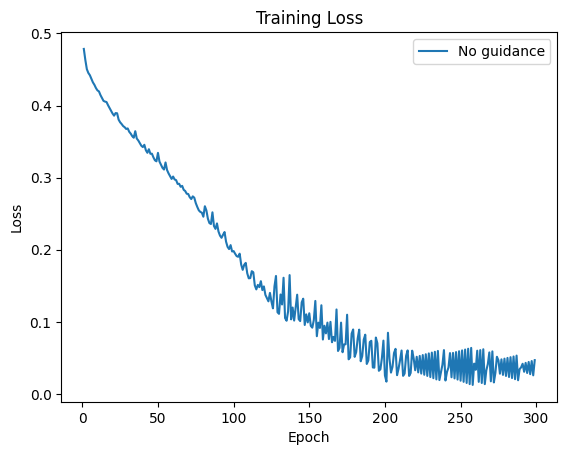

In [21]:
# ----------------------------------------------------------------------------
# ----------------- Plot the loss function -----------------------------------

plot_loss(values = [loss_vals_a], names = ["No guidance"])

## Fine-tuning using the guidance matrix

In [22]:
# -------------------------------------------------------------------------------------------------------
# --------------- Load the guidance matrix and adjust it ------------------------------------------------

guidance_matrix = gtl.load_guidance_matrix()     # -using gtl library----------
gtl.adjust_guidance_matrix(guidance_matrix, gtl.Focus.ZERO_ENFORCED_AND_NORMALIZED, gtl.Temp.WARM)
gtl.scale_guidance_matrix(guidance_matrix, 2)    # -using gtl library----------

{'linear1.weight': tensor([[1.0386, 1.0483],
         [1.0081, 1.0961],
         [1.0101, 1.1734],
         ...,
         [1.3250, 1.0173],
         [1.0194, 1.0299],
         [1.0055, 1.1039]], device='cuda:0'),
 'linear1.bias': tensor([1.0076, 1.0081, 1.2292, 1.4265, 1.0001, 1.3982, 1.0744, 1.0252, 1.0041,
         1.0111, 1.0502, 1.1236, 1.1501, 1.0029, 1.2743, 1.4282, 1.0874, 1.1196,
         1.2204, 1.1893, 1.2031, 1.0284, 1.0271, 1.0005, 1.0649, 1.3786, 1.8288,
         1.0107, 1.0310, 1.1029, 1.0172, 1.0018, 1.0703, 1.8871, 1.0034, 1.0008,
         1.4871, 1.0955, 1.1585, 1.1822, 1.0392, 1.0005, 1.2000, 1.1384, 1.3683,
         1.1888, 1.0015, 1.1394, 1.0101, 1.1181, 1.0754, 1.1518, 1.3993, 1.4607,
         1.0072, 1.0097, 1.0013, 1.1799, 1.0520, 1.4954, 1.8743, 1.0028, 1.4213,
         1.0081, 1.2910, 1.7145, 1.2151, 1.1660, 1.1412, 1.0215, 1.0105, 1.1881,
         1.6650, 1.0558, 1.1607, 1.6588, 1.3953, 1.0632, 1.3255, 1.0061, 1.5073,
         1.1885, 1.0911, 1.0679, 1.0250, 1

In [23]:
# -------------------------------------------------------------------------------------------------------
# --------------- Load the model and train it on XOR problem using guidance matrix ----------------------

g_model = TinyModel().to(device)
gtl.load_base(g_model)                          # -----------using gtl library to load the base model

loss_vals_g = train_model(model=g_model, x=base_train_X2, y=base_train_Y2, epochs=299, guidance_matrix=guidance_matrix, lr = 0.01)

Epoch: 1 Loss: 0.47846797
Epoch: 50 Loss: 0.3000664
Epoch: 100 Loss: 0.13234517
Epoch: 150 Loss: 0.055505194
Epoch: 200 Loss: 0.06613903
Epoch: 250 Loss: 0.019781351
Epoch: 299 Loss: 0.046855066


In [24]:
# --------------------------------------------------------------------------------------------------------------------
# ----------------- Test the performance on the test data (the same as train data) -----------------------------------

test_model(g_model, base_test_X2, base_test_Y2)

Perfect output:
 [[0.1 0.1]
 [1.  1. ]
 [1.  1. ]
 [0.1 0.1]]
Actual output:
 [[0.10447475 0.11635074]
 [1.0185261  1.0184935 ]
 [1.0527573  1.0606009 ]
 [0.11164726 0.11720853]]

Loss: 0.025007378


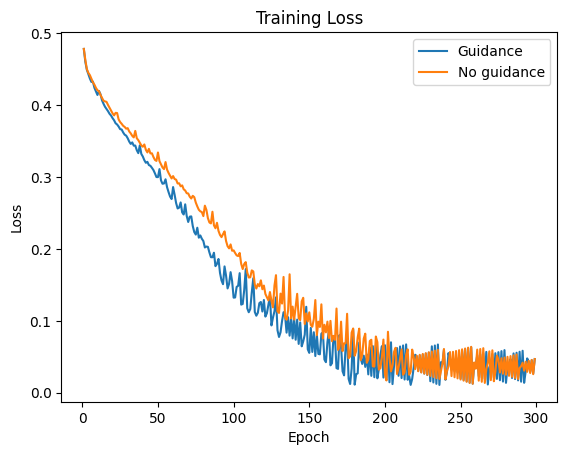

In [25]:
# --------------------------------------------------------------------------------
# ----------------- Compare the loss functions -----------------------------------

plot_loss(values = [loss_vals_g, loss_vals_a], names = [ "Guidance", "No guidance"])


# Note that for this problem, in which no generalization from train to test data is required,
# a guiding matrix does not show an advantage (or shows negligible advantage). This is because
# the function of a guiding matrix is primarily to act as a regularization technique that 
# prevents overfit with small training data sets, which is applicable to tasks that 
# require a model to generalize from train to test data.

# The purpose of this simplification in the present demo is to facilitate user's learning on
# how to apply the GTL library. 

# Additional functions of the GTL library

## Exploring the conents of models

In [26]:
model = TinyModel().to(device)
gtl.load_base(model)             # ----------using gtl library to load a model 
 
print(gtl.list_params(model))  # ----using gtl library to list the names of parameters and dimensionality

[('linear1.weight', torch.Size([1000, 2])), ('linear1.bias', torch.Size([1000])), ('linear2.weight', torch.Size([250, 1000])), ('linear2.bias', torch.Size([250])), ('linear3.weight', torch.Size([2, 250])), ('linear3.bias', torch.Size([2]))]


In [27]:

print(gtl.get_param_values(model, 3)) # ----using gtl library to list the first few values of the model parameters

# Another handy function to print the few values of each parameter name to monitor changes in values

[tensor([[-0.1971,  0.0543],
        [ 0.2954,  0.2111],
        [ 0.2115, -0.2913]], device='cuda:0', grad_fn=<SliceBackward0>), tensor([ 0.5242, -0.3127, -0.0046], device='cuda:0', grad_fn=<SliceBackward0>), tensor([[ 0.0163,  0.0197, -0.0261,  ...,  0.0257, -0.0181, -0.0146],
        [-0.0255,  0.0121, -0.0291,  ..., -0.0134,  0.0065,  0.0271],
        [-0.0155,  0.0015, -0.0250,  ..., -0.0301,  0.0022, -0.0278]],
       device='cuda:0', grad_fn=<SliceBackward0>), tensor([ 0.0131,  0.0193, -0.0008], device='cuda:0', grad_fn=<SliceBackward0>), tensor([[ 2.4020e-02,  2.4801e-03, -3.4409e-02,  1.7149e-02, -1.5907e-02,
         -5.4030e-02, -4.4583e-02, -2.6649e-02,  1.3501e-02,  2.0000e-02,
          3.9227e-03, -5.0046e-02,  1.7641e-02, -7.2423e-02,  1.8138e-02,
          2.7781e-02, -3.1702e-02, -6.2054e-02,  7.0387e-02,  2.0699e-02,
          3.4396e-02,  4.0050e-02,  4.3848e-02,  1.5216e-02, -1.2527e-02,
          1.0113e-04, -2.2860e-02, -5.1308e-02,  4.2531e-02, -1.5785e-02,
    

## Scouts and guidance matrices

### Creating scout indexes using ranges 

In [28]:
# The above approach can be confusing due to the need to enter i+1. For that reason, 
# GTL library allows one more possibility  
# enter the exact start and end... 
                
# -----------------------------using gtl library-----------------------------------------
#Let us say we have the following list of indexes to form three scouts:

scout_indexes_A = [[1,3,12],                          # scout_1
                   [7,8,9,10],                        # scout_2
                   [3,4,5,6,7,8,22,28]]               # scout_3
                   
# One can notice that some of the indexes are consecutive e.g., 7 to 10 and 3 to 8. 
# Entering manually long sequences of consecutive numbers can be impractical.
# It is more practical to enter just the beginning and the end of a list.
# Python function list() and range() can be helpful to simplify entering the list 
# for scout_2: 
#     list(range(7, 11)
# However, this does not allow simplifying scout_3, which combines a consecutive sequence 
# with two non-consecutive numbers (a sequence 3 to 8 followed by 22 and 28).

# To facilitate specifying indexes for scouts consisting of a mixture of consecutive
# and non-consecutive number sequences, gtl library offers two possibilities.

# 1) Specify the beginning and the end of a consecutive sequence list using sub-lists of length one:

scout_indexes_B = [[1,3,12],                   # scout_1
                   [[7],[10]],                 # scout_2
                   [[3],[8],22,28]]            # scout_3

# After that call gtl.expand_scout_indexes() to expand the list

scout_indexes_B = gtl.expand_scout_indexes(scout_indexes_B)

# This will produce the idential result and entering the values manually.

print("A:", scout_indexes_A)
print("B:", scout_indexes_B)


# 2) If number 1 does not provide sufficient clarity of feels non-pythonic, it is possible to specify
#    the beginning and the end of a consecutive sequence list using a helper function gtl.c():

scout_indexes_C = [[1,3,12],                       # scout_1
                   [gtl.c(7), gtl.c(10)],          # scout_2
                   [gtl.c(3), gtl.c(8), 22,28]]    # scout_3

# which will produce idential results as the above approache

scout_indexes_C = gtl.expand_scout_indexes(scout_indexes_C)
print("C:", scout_indexes_C)


A: [[1, 3, 12], [7, 8, 9, 10], [3, 4, 5, 6, 7, 8, 22, 28]]
B: [[1, 3, 12], [7, 8, 9, 10], [3, 4, 5, 6, 7, 8, 22, 28]]
C: [[1, 3, 12], [7, 8, 9, 10], [3, 4, 5, 6, 7, 8, 22, 28]]


### Inspecting the guidance matrix

In [29]:
# Load a guidance matrix
guidance_matrix = gtl.load_guidance_matrix()        # ----------using gtl library----------

In [30]:
# Use get_guide_values() to print some of the values in guidance matrix
print(gtl.get_guidance_values(guidance_matrix))     # ----------using gtl library

{'linear1.weight': tensor([[0.5193, 0.5242],
        [0.5041, 0.5481],
        [0.5051, 0.5867],
        ...,
        [0.6625, 0.5087],
        [0.5097, 0.5149],
        [0.5027, 0.5519]], device='cuda:0'), 'linear1.bias': tensor([0.5038, 0.5041], device='cuda:0'), 'linear2.weight': tensor([[0.5054, 0.5224],
        [0.5035, 0.5052],
        [0.5691, 0.5053],
        [0.5089, 0.5000],
        [0.6661, 0.5141],
        [0.6141, 0.8758],
        [0.5027, 0.7033],
        [0.6060, 0.5725],
        [0.5202, 0.6014],
        [0.5057, 0.5000],
        [0.5620, 0.5736],
        [0.5045, 0.5270],
        [0.5359, 0.5897],
        [0.5611, 0.5445],
        [0.5026, 0.5754],
        [0.5001, 0.5049],
        [0.5295, 0.5287],
        [0.5924, 0.5496],
        [0.5068, 0.5277],
        [0.5038, 0.5372],
        [0.7865, 0.5390],
        [0.5010, 0.5024],
        [0.6493, 0.5395],
        [0.7074, 0.7236],
        [0.5384, 0.5435],
        [0.5300, 0.5008],
        [0.5841, 0.5794],
        [0.507

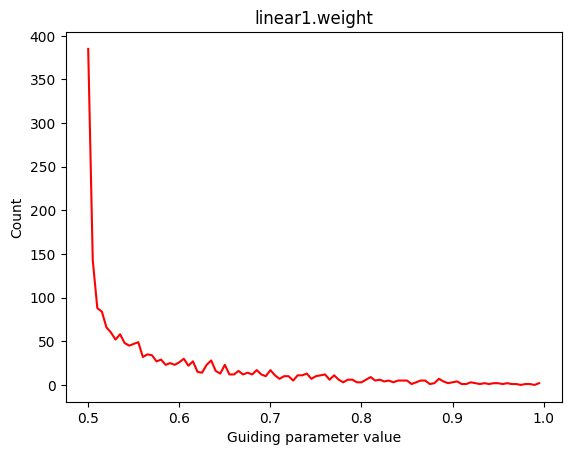

In [31]:
# A GTL function to plot the distribution of values in the guidance matrix
gtl.plot_guidance_distribution(guidance_matrix, name="linear1.weight")    # ----------using gtl library


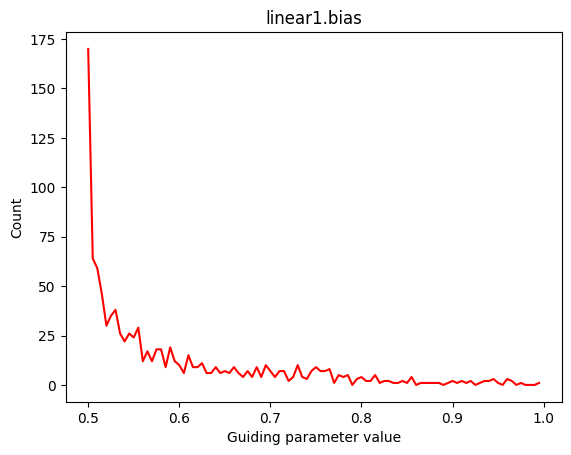

In [32]:
gtl.plot_guidance_distribution(guidance_matrix, name="linear1.bias")    # ----------using gtl library

### Adjusting guidance matrix

In [33]:
gtl.adjust_guidance_matrix(guidance_matrix, gtl.Focus.ZERO_ENFORCED_AND_NORMALIZED, gtl.Temp.WARM)
gtl.scale_guidance_matrix(guidance_matrix, 2)   # ----------using gtl library

{'linear1.weight': tensor([[1.0386, 1.0483],
         [1.0081, 1.0961],
         [1.0101, 1.1734],
         ...,
         [1.3250, 1.0173],
         [1.0194, 1.0299],
         [1.0055, 1.1039]], device='cuda:0'),
 'linear1.bias': tensor([1.0076, 1.0081, 1.2292, 1.4265, 1.0001, 1.3982, 1.0744, 1.0252, 1.0041,
         1.0111, 1.0502, 1.1236, 1.1501, 1.0029, 1.2743, 1.4282, 1.0874, 1.1196,
         1.2204, 1.1893, 1.2031, 1.0284, 1.0271, 1.0005, 1.0649, 1.3786, 1.8288,
         1.0107, 1.0310, 1.1029, 1.0172, 1.0018, 1.0703, 1.8871, 1.0034, 1.0008,
         1.4871, 1.0955, 1.1585, 1.1822, 1.0392, 1.0005, 1.2000, 1.1384, 1.3683,
         1.1888, 1.0015, 1.1394, 1.0101, 1.1181, 1.0754, 1.1518, 1.3993, 1.4607,
         1.0072, 1.0097, 1.0013, 1.1799, 1.0520, 1.4954, 1.8743, 1.0028, 1.4213,
         1.0081, 1.2910, 1.7145, 1.2151, 1.1660, 1.1412, 1.0215, 1.0105, 1.1881,
         1.6650, 1.0558, 1.1607, 1.6588, 1.3953, 1.0632, 1.3255, 1.0061, 1.5073,
         1.1885, 1.0911, 1.0679, 1.0250, 1

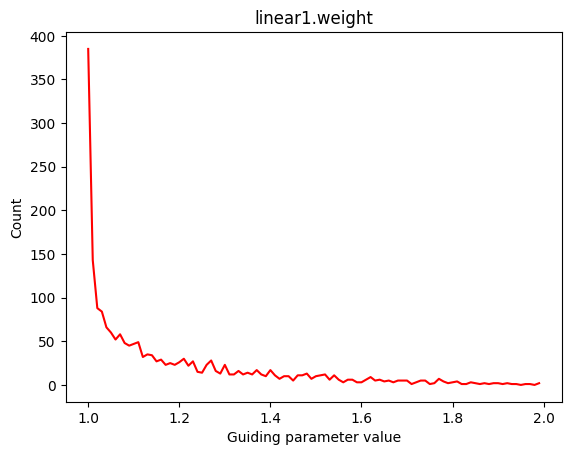

In [34]:
# plot the distribution of the matrix after the adjusting
gtl.plot_guidance_distribution(guidance_matrix, name="linear1.weight")    # ----------using gtl library

In [35]:
#Other possible ways to adjust the guidance matrix
gtl.adjust_guidance_matrix(guidance_matrix, gtl.Focus.ZERO_ENFORCED_AND_NORMALIZED, gtl.Temp.CHILLY)
gtl.adjust_guidance_matrix(guidance_matrix, gtl.Focus.ZERO_ENFORCED_AND_NORMALIZED, gtl.Temp.FREEZING)
gtl.adjust_guidance_matrix(guidance_matrix, gtl.Focus.ZERO_ENFORCED_AND_NORMALIZED, gtl.Temp.WARM)
gtl.adjust_guidance_matrix(guidance_matrix, gtl.Focus.ZERO_ENFORCED_AND_NORMALIZED, gtl.Temp.EVAPORATING)
gtl.adjust_guidance_matrix(guidance_matrix, gtl.Focus.ZERO_ENFORCED_AND_NORMALIZED, gtl.Temp.ICY)

{'linear1.weight': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]], device='cuda:0'),
 'linear1.bias': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

In [36]:
del guidance_matrix